In [6]:
# libraries to import
import numpy as np
import matplotlib.pyplot as plt

# Stochastic Linear Bandits

### This is how the algorithm works :

### Steps of the algorithm

In [79]:
# values we know prior to running the algorithm
n_arms = 10
n_features = 5
true_theta = np.random.rand(n_features)
item_features = np.random.rand(n_features, n_arms)
n_rounds = 100
noise = 1.0

# confidence parameter
alpha = 1.0

# --------- Start of the algorithm LinUCB -----------



def linUCB_algorithm(n_arms, n_features, item_features, true_theta, n_rounds, noise, lambda_param, beta_param, delta_param):
    
    # Initialize feature matrix.
    # V_t[i, j] represents the sum of the product of the ith and jth feature components across all observed data points.
    # V_t[i, i] represents the sum of the squared ith feature components.
    # Initializing V_0 to lambda * Identity matrix makes it invertible.
    V_t = lambda_param * np.eye(n_features)

    # Initialize label vector.
    # Represents the sum of the product of the observed rewards with each feature component across all observed data points.
    sum_A_s_X_s = np.zeros(n_features)
    
    # Initialize theta_hat matrix, where each column represents the estimate of the true_theta vector at each round.
    theta_hat = np.zeros((n_features, n_rounds + 1))

    # Initialize arrays to store actions, rewards and regrets.
    actions = np.zeros(n_rounds + 1, dtype=int)
    rewards = np.zeros(n_rounds + 1)
    regrets = np.zeros(n_rounds + 1)
    
    print("theta at time step 0 : ")
    print(theta_hat[:, 0])

    for t in range(1, n_rounds + 1):
        
        # Compute beta parameter for this round using the given formula.
        beta_param_t = 2 * np.log(t * lambda_param / delta_param) # 2 * np.log(t * n_arms * lambda_param / delta_param)
        print("beta param : " + str(beta_param_t))
        
        # Choose the best action based on the last theta_hat.
        max_value = -np.Inf;
        max_index = -1
        for i in range(n_arms):
            # Compute the value of each action using the given formula.
            value = theta_hat[:, t-1].T @ item_features[:, i] + np.sqrt(beta_param_t) * np.sqrt(item_features[:, i].T @ np.linalg.inv(V_t) @ item_features[:, i])
            print("Value for arm " + str(i) + " : " + str(value))
            if value >= max_value:
                max_value = value
                max_index = i
        # Update the best action to take for this round.
        actions[t] = max_index
        
        print("best action to take : " + str(actions[t]))
        
        # Observe the reward of the chosen action and add noise.
        rewards[t] = true_theta.T @ item_features[:, actions[t]] + np.random.normal(scale=noise) # this might be the reason why we get negative regret
        
        print("current reward of chosen action : " + str(rewards[t]))
        
        # Compute the regret for this round.
        optimal_reward = np.max(item_features.T @ true_theta) # todo put this outside the for loop
        print("optimal reward possible : " + str(optimal_reward) + " with arm " + str(np.argmax(item_features.T @ true_theta)))
        regret = optimal_reward - rewards[t]
        print("regret : " + str(regret))
        regrets[t] = regrets[t - 1] + regret
        
        # Update the feature matrix V_t by adding the outer product of the chosen action's feature vector with itself.
        V_t += item_features[:, actions[t]] @ item_features[:, actions[t]].T 
        
        # Compute the inverse of the updated feature matrix V_t.
        V_t_inv = np.linalg.inv(V_t)

        # Update the label vector sum_A_s_X_s by adding the outer product of the chosen action's feature vector with the observed reward.
        sum_A_s_X_s += item_features[:, actions[t]] * rewards[t]
        
        # Compute the new estimate of the true_theta vector using the updated feature matrix and label vector.
        # This estimate represents the center of the ellipsoid in the feature space.
        theta_hat_not_normalized = V_t_inv @ sum_A_s_X_s
        theta_hat[:, t] = V_t_inv @ sum_A_s_X_s # theta_hat_not_normalized / np.linalg.norm(theta_hat_not_normalized) # todo idk if we should normalize this np.linalg.norm()
        
        print("theta at time step " + str(t) + " : ")
        print(theta_hat[:, t])
        
        print(" -------------\n ")
        
    return actions, rewards, regrets, theta_hat[:, n_rounds]


theta at time step 0 : 
[0. 0. 0. 0. 0.]
beta param : 7.824046010856292
Value for arm 0 : 7.751253801140409
Value for arm 1 : 4.7805529651994805
Value for arm 2 : 6.437071620427109
Value for arm 3 : 4.553487896724336
Value for arm 4 : 5.634840717585072
Value for arm 5 : 5.971619881558581
Value for arm 6 : 4.677098352751963
Value for arm 7 : 4.774298082293958
Value for arm 8 : 5.775897953423029
Value for arm 9 : 5.688240801564937
best action to take : 0
current reward of chosen action : 0.5607740786495397
optimal reward possible : 1.2635873431676663 with arm 5
regret : 0.7028132645181266
theta at time step 1 : 
[ 0.93561355  0.93167086 -1.21692635  0.490888   -1.12299841]
 -------------
 
beta param : 9.210340371976184
Value for arm 0 : 12.538242205148677
Value for arm 1 : 5.499108692194048
Value for arm 2 : 8.118494571866
Value for arm 3 : 5.57523598454784
Value for arm 4 : 4.035836424946723
Value for arm 5 : 6.733031010585377
Value for arm 6 : 5.428917173349907
Value for arm 7 : 5.129

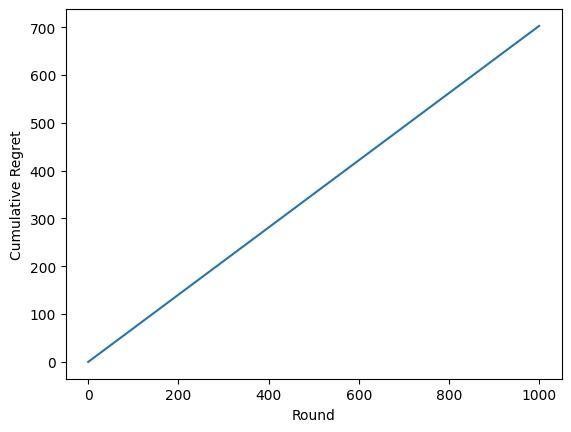

The true theta is equal to : [[ 0.63841482]
 [-0.28130794]
 [-0.93878313]
 [-0.54812423]
 [ 0.42867799]]
The theta hat we find at the end is equal to : [ 0.4286859   0.42687234 -0.56143794  0.22412134 -0.51823303]


In [80]:
# Setting up parameters for the runs
n_arms = 10
n_features = 5
item_features = np.random.uniform(low=-1, high=1, size=(n_features, n_arms))
true_theta = np.random.uniform(low=-1, high=1, size=(n_features, 1))
n_rounds = 1000
noise = 0.0 # 0.1 -> can lead to negative regret since the reward could be the optimal + some noise
beta_param = 6
lambda_param = 0.5
delta_param = 0.1

# Running the algorithm
actions, rewards, regrets, theta_hat = linUCB_algorithm(n_arms, n_features, item_features, true_theta, n_rounds, noise, lambda_param, beta_param, delta_param)

# Plotting the regret
plt.plot(regrets)
plt.xlabel('Round')
plt.ylabel('Cumulative Regret')
plt.show()

# Printing the true theta a
print("The true theta is equal to : " + str(true_theta))
print("The theta hat we find at the end is equal to : " + str(theta_hat / np.linalg.norm(theta_hat)))

In [75]:
print(true_theta)
print(item_features)

[[-0.90946993]
 [-0.98566896]
 [ 0.65181493]
 [-0.63342807]
 [-0.71930043]]
[[ 0.95495922  0.93183194  0.28719258 -0.44548345  0.34707461  0.03278525
   0.76012984  0.19711222 -0.7679968  -0.04557182]
 [ 0.81989815 -0.32802621  0.17746884 -0.55418938 -0.66676611 -0.47367687
   0.57645191 -0.5572539  -0.35776183 -0.54530232]
 [ 0.64865819 -0.3077634  -0.66703249 -0.00685859 -0.4115614  -0.23283854
   0.09707146 -0.95915083 -0.72106189 -0.16219222]
 [-0.60787256 -0.4925727  -0.58348649 -0.00343192 -0.00914787 -0.97983546
   0.26779698 -0.26062153  0.40348038  0.13913592]
 [-0.99823907 -0.96365939 -0.84271153 -0.67919332 -0.23099696 -0.17697977
  -0.17338048  0.88271626 -0.41010481  0.61118781]]


In [ ]:
# I will wrap everything in a class when I get a working algorithm

# class UCB_linear_bandit:
#     def __init__(self, true_theta, item_features, num_rounds, noise):
#         self.true_theta = true_theta
#         self.item_features = item_features
#         self.num_rounds = num_rounds
#         self.noise = noise
        
#         self.actions = np.zeros(num_rounds)
#         self.regrets = np.zeros(num_rounds)